# Figure 2: Latent space interpretability and batch correction

In [1]:
import cytovi
import anndata as ad
import pandas as pd
import numpy as np
import os
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_use_gpu' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
os.chdir('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/notebooks/')
figure_dir = '../figures/figure2/'

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["savefig.dpi"] = 300

sc.settings.figdir = figure_dir
sc.set_figure_params(dpi_save = 300)
sc.settings.n_jobs = 60

## load flow data and inspect latent space


In [3]:
# load flow data and model from disk
adata_flow = ad.read_h5ad('../data/raw/Spectral flow/Nunez/For Chiquito/annotated/2024-01-24_norm_sample_batch1_ann.h5ad')
model_path = '../models/dist_eval/2024-07-10_aurora_normal_scaled/'
model_flow = cytovi.CytoVI.load(model_path, adata = adata_flow)

INFO     File ../models/dist_eval/2024-07-10_aurora_normal_scaled/model.pt already downloaded                      


In [4]:
# generate umap of latent
adata_flow.obsm["X_CytoVI_normal_scaled"] = model_flow.get_latent_representation()
sc.pp.neighbors(adata_flow, use_rep="X_CytoVI_normal_scaled", key_added= 'neighbors_CytoVI_normal_scaled')
sc.tl.umap(adata_flow, neighbors_key = 'neighbors_CytoVI_normal_scaled')
adata_flow.obsm["X_umap_CytoVI_normal_scaled"] = adata_flow.obsm['X_umap'].copy()

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit fo

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


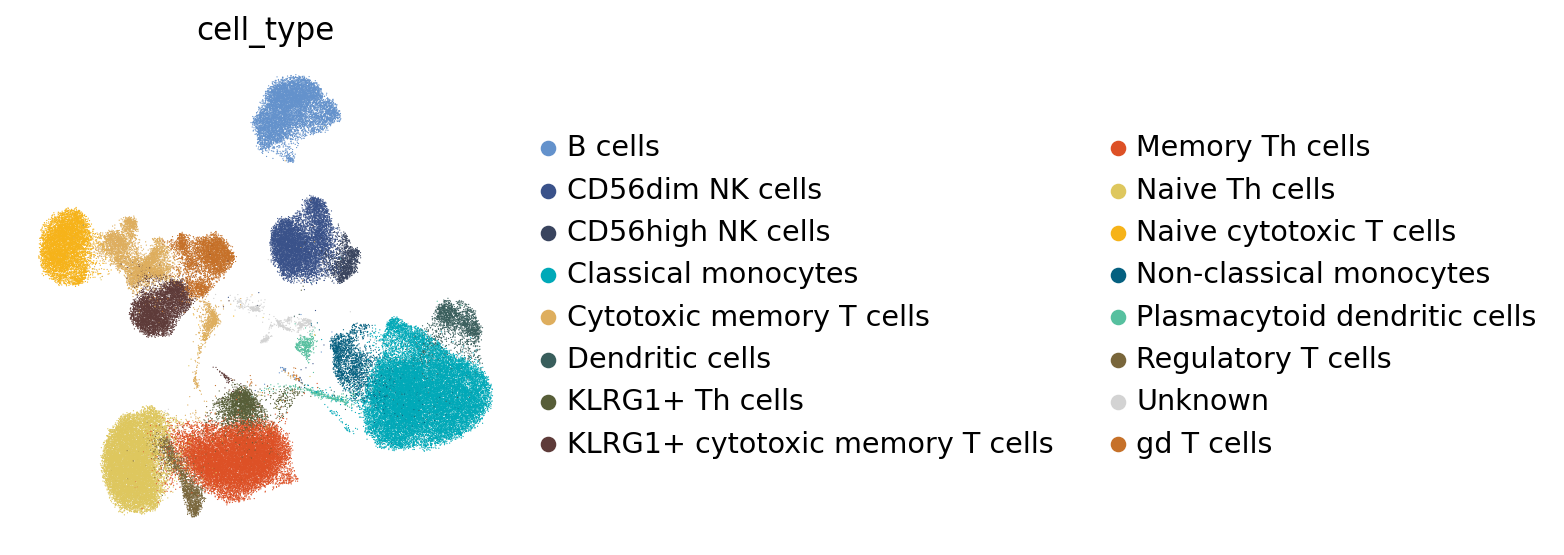

In [64]:
# plot latent space
cell_type_colors = {
    'Naive cytotoxic T cells': '#F6B319',
    'Classical monocytes': '#00A9B8',
    'Cytotoxic memory T cells': '#DEAE5E',
    'Memory Th cells': '#DD5126',
    'CD56dim NK cells': '#3A528A',
    'B cells': '#6492CC',
    'Naive Th cells': '#DEC75E',
    'KLRG1+ cytotoxic memory T cells': '#5E3B39',
    'gd T cells': '#C67129',
    'Unknown': 'lightgrey',
    'Non-classical monocytes': '#056080',
    'CD56high NK cells': '#39445E',
    'KLRG1+ Th cells': '#575E38',
    'Regulatory T cells': '#79663B',
    'Dendritic cells': '#395E5C',
    'Plasmacytoid dendritic cells': '#56C09F'
}

sc.pl.embedding(adata_flow, basis = 'X_umap_CytoVI_normal_scaled', color='cell_type', palette=cell_type_colors, frameon=False, save='flow_cell_types.png')

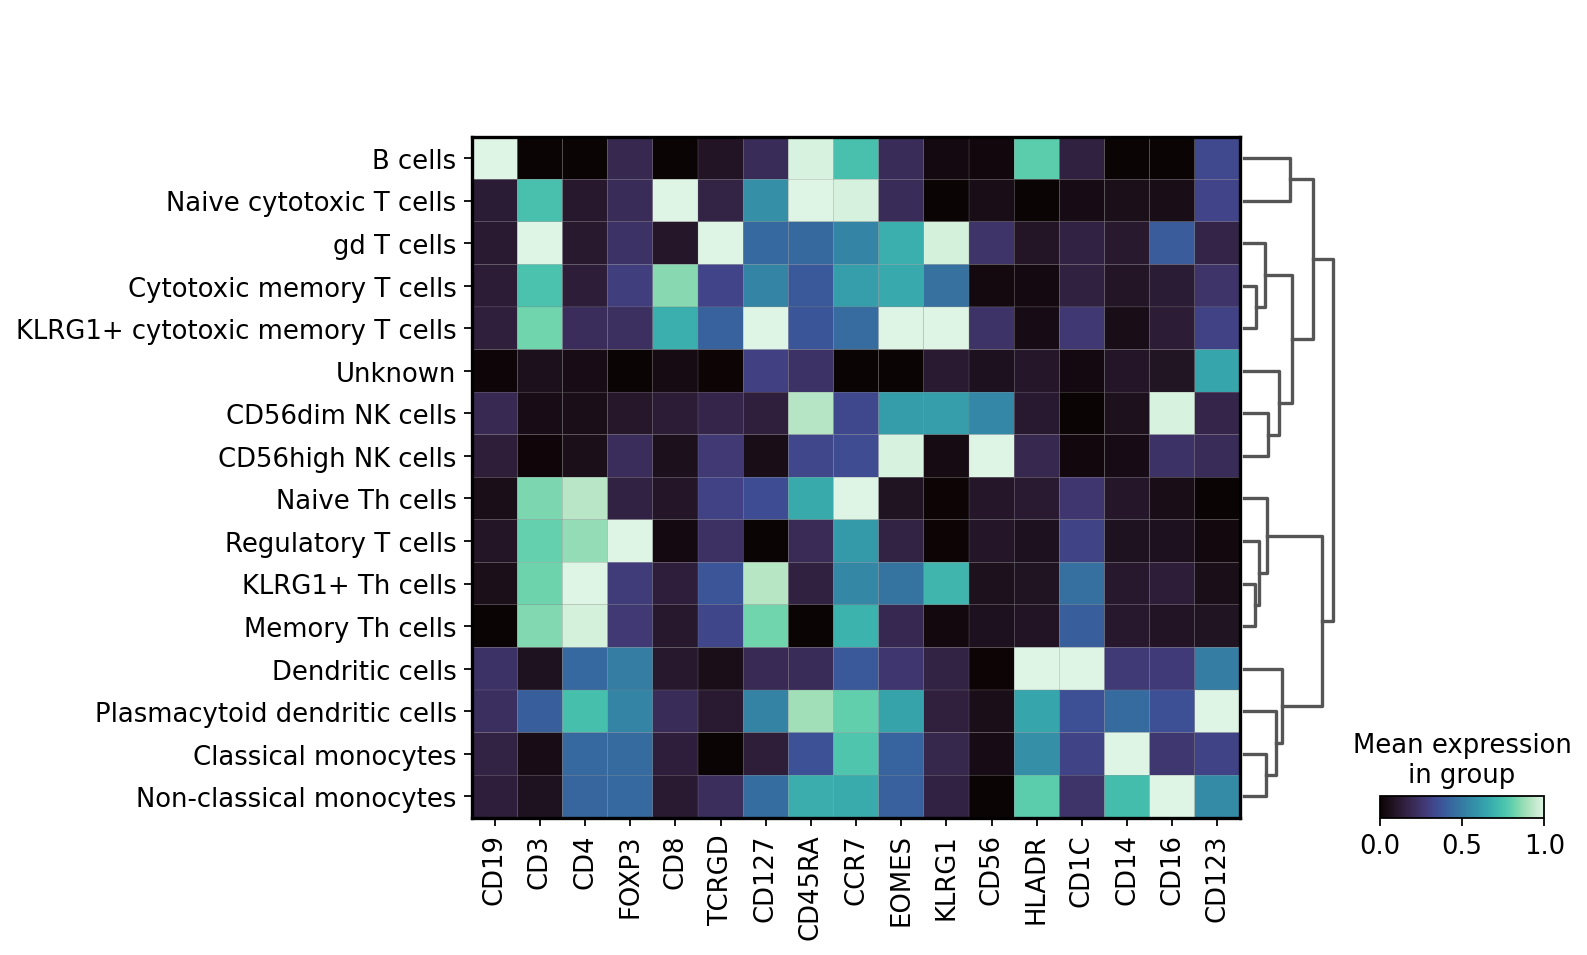

In [9]:
flow_markers = ['CD19', 'CD3', 'CD4','FOXP3', 'CD8', 'TCRGD', 'CD127', 'CD45RA', 'CCR7', 'EOMES', 'KLRG1', 'CD56', 'HLADR', 'CD1C', 'CD14', 'CD16', 'CD123']
sc.pl.matrixplot(adata_flow, var_names=flow_markers, groupby='cell_type', layer='scaled', standard_scale='var', cmap='mako', dendrogram = True, save = 'flow_cell_type_expression_heatmap_selected_markers.pdf')

In [27]:
# cluster CytoVI latent space
sc.tl.leiden(adata_flow, key_added="leiden_CytoVI", resolution=1, neighbors_key='neighbors_CytoVI_normal_scaled')

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


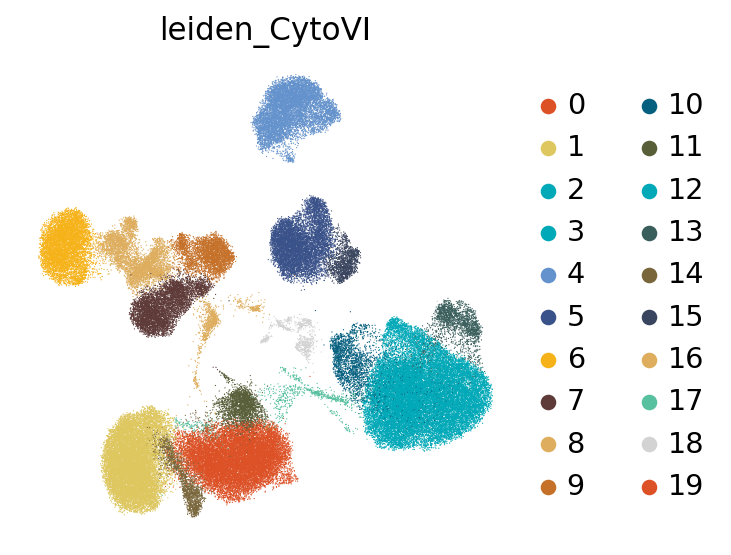

In [63]:
# plot leiden clusters on latent space
color_dict_leiden = {
    '0': '#DD5126',
    '1': '#DEC75E',
    '2': '#00A9B8',
    '3': '#00A9B8',
    '4': '#6492CC',
    '5': '#3A528A',
    '6': '#F6B319',
    '7': '#5E3B39',
    '8': '#DEAE5E',
    '9': '#C67129',
    '10': '#056080',
    '11': '#575E38',
    '12': '#00A9B8',
    '13': '#395E5C',
    '14': '#79663B',
    '15': '#39445E',
    '16': '#DEAE5E',
    '17': '#56C09F',
    '18': 'lightgrey',
    '19': '#DD5126'
}

sc.pl.embedding(adata_flow, basis = 'X_umap_CytoVI_normal_scaled', color='leiden_CytoVI', palette=color_dict_leiden, frameon=False, save='flow_leiden.png')

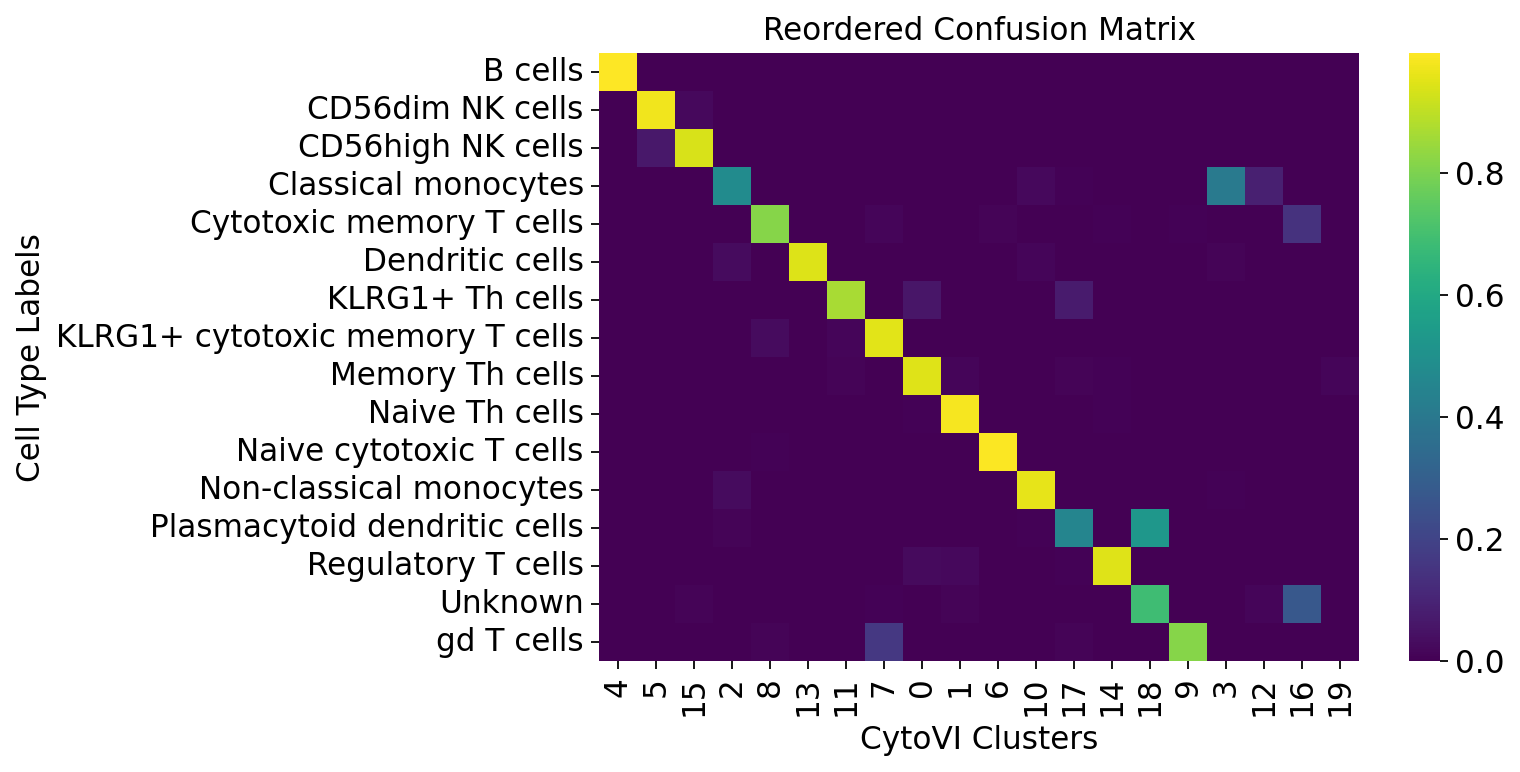

In [53]:
from scipy.optimize import linear_sum_assignment

# compute confusion matrix
confusion_matrix_df = sc.metrics.confusion_matrix("cell_type", "leiden_CytoVI", adata_flow.obs)

# reorder confusion matrix using linear sum assignment
n_rows, n_cols = confusion_matrix_df.shape

if n_rows > n_cols:
    padded_confusion_matrix = np.pad(confusion_matrix_df.values, ((0, 0), (0, n_rows - n_cols)), mode='constant')
else:
    padded_confusion_matrix = np.pad(confusion_matrix_df.values, ((0, n_cols - n_rows), (0, 0)), mode='constant')

cost_matrix = padded_confusion_matrix.max() - padded_confusion_matrix
row_ind, col_ind = linear_sum_assignment(cost_matrix)

reordered_matrix_array = confusion_matrix_df.values[:, col_ind[:n_cols]]
reordered_matrix_df = pd.DataFrame(reordered_matrix_array, index=confusion_matrix_df.index, columns=confusion_matrix_df.columns[col_ind[:n_cols]])

# plot
fig, ax = plt.subplots(figsize=(8, 5))
g = sns.heatmap(reordered_matrix_df, cmap="viridis", cbar=True, ax = ax, square = True)
ax.set_title('Reordered Confusion Matrix')
ax.set_xlabel('CytoVI Clusters')
ax.set_ylabel('Cell Type Labels')
fig.savefig(figure_dir + 'flow_confusion_matrix.pdf')

plt.show()

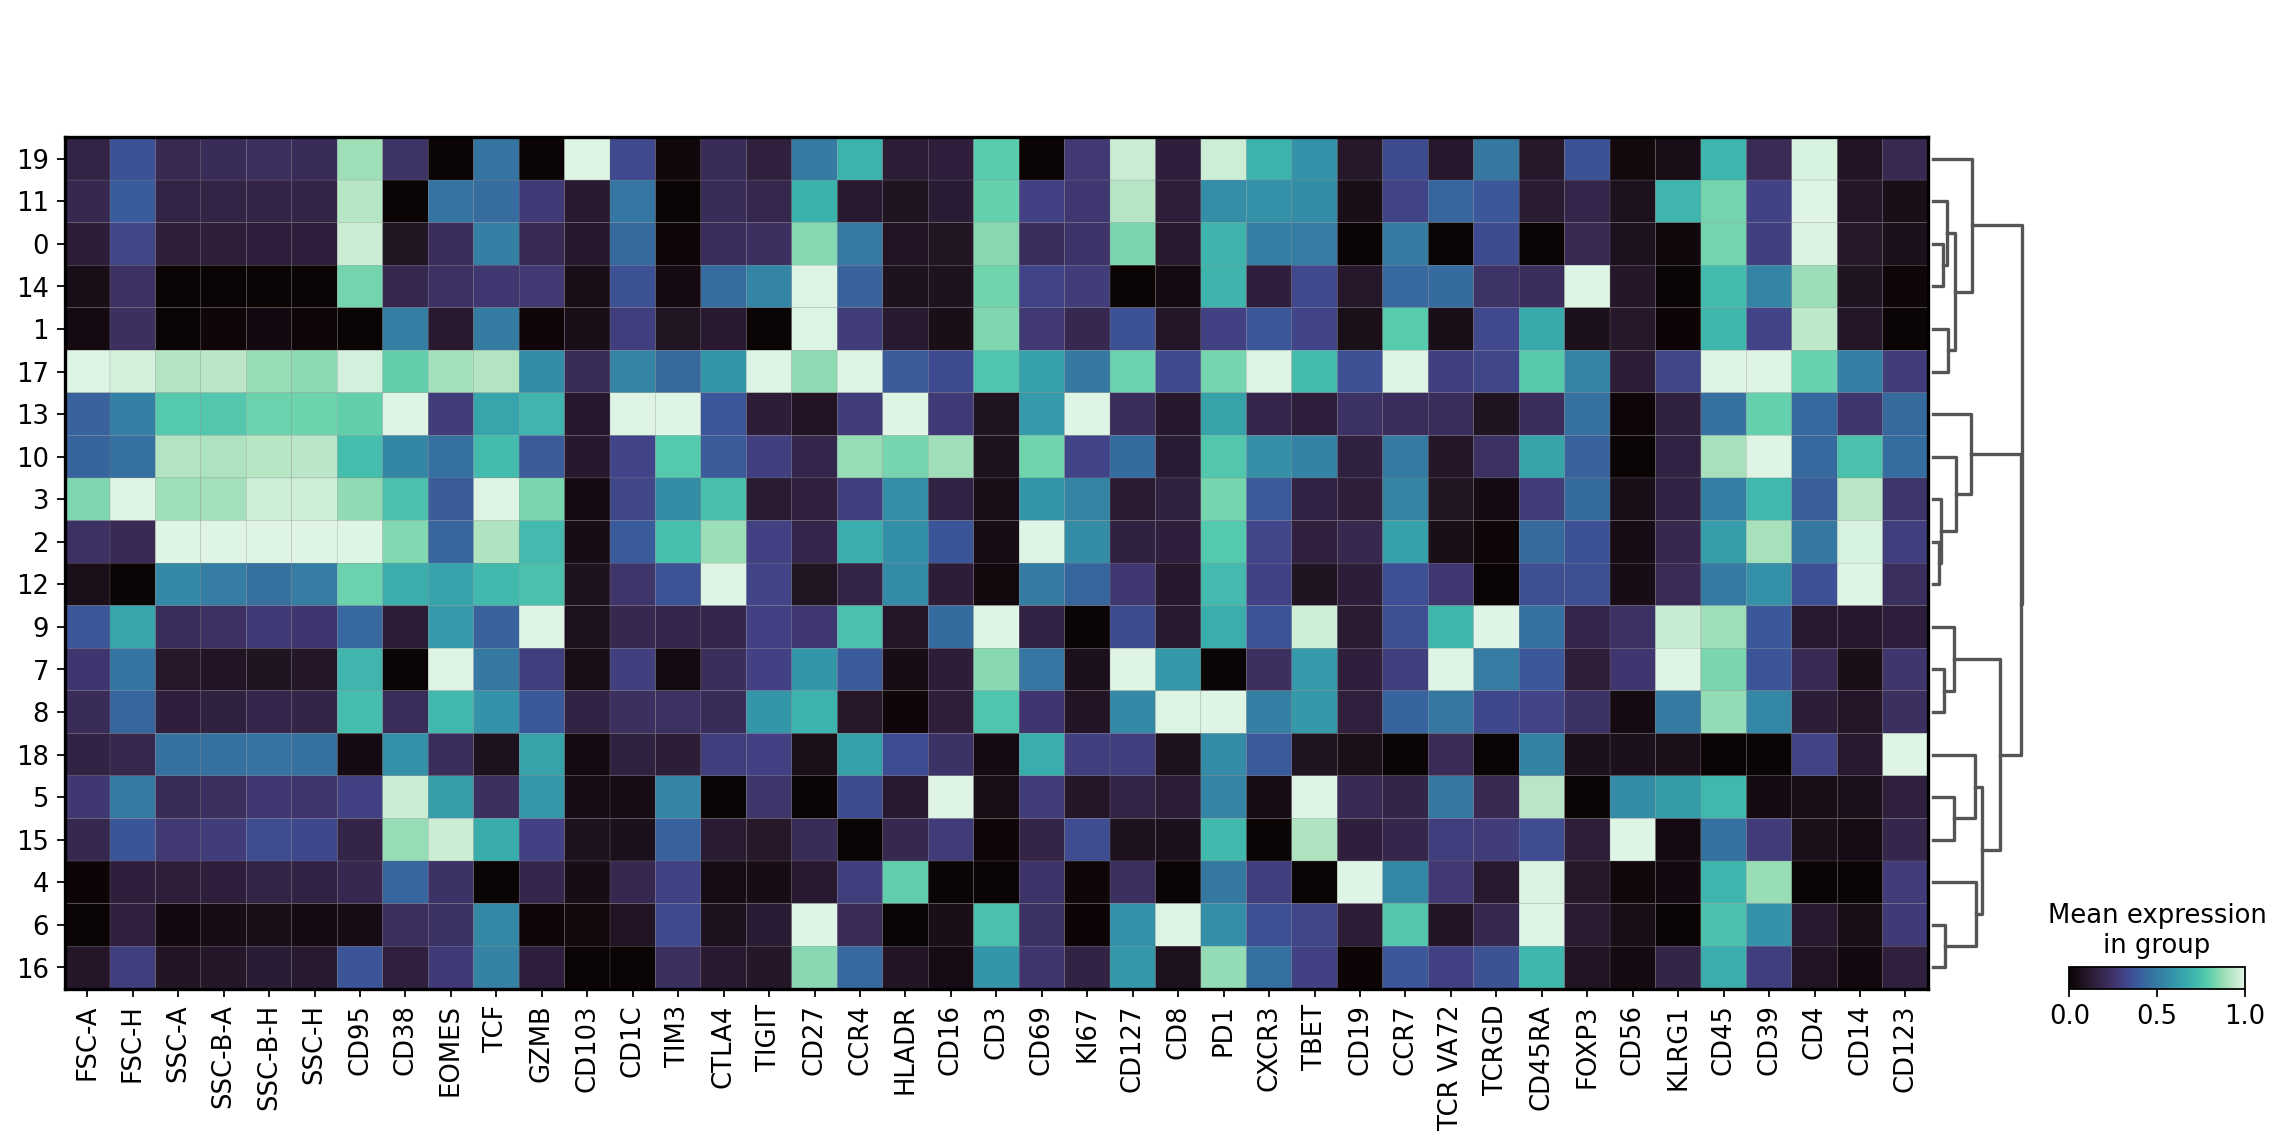

In [62]:
# expression matrix of leiden clusters
sc.pl.matrixplot(adata_flow, var_names=adata_flow.var_names, groupby='leiden_CytoVI', layer='scaled', standard_scale='var', cmap='mako', dendrogram = True, save = 'flow_leiden_expression_heatmap.pdf')

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


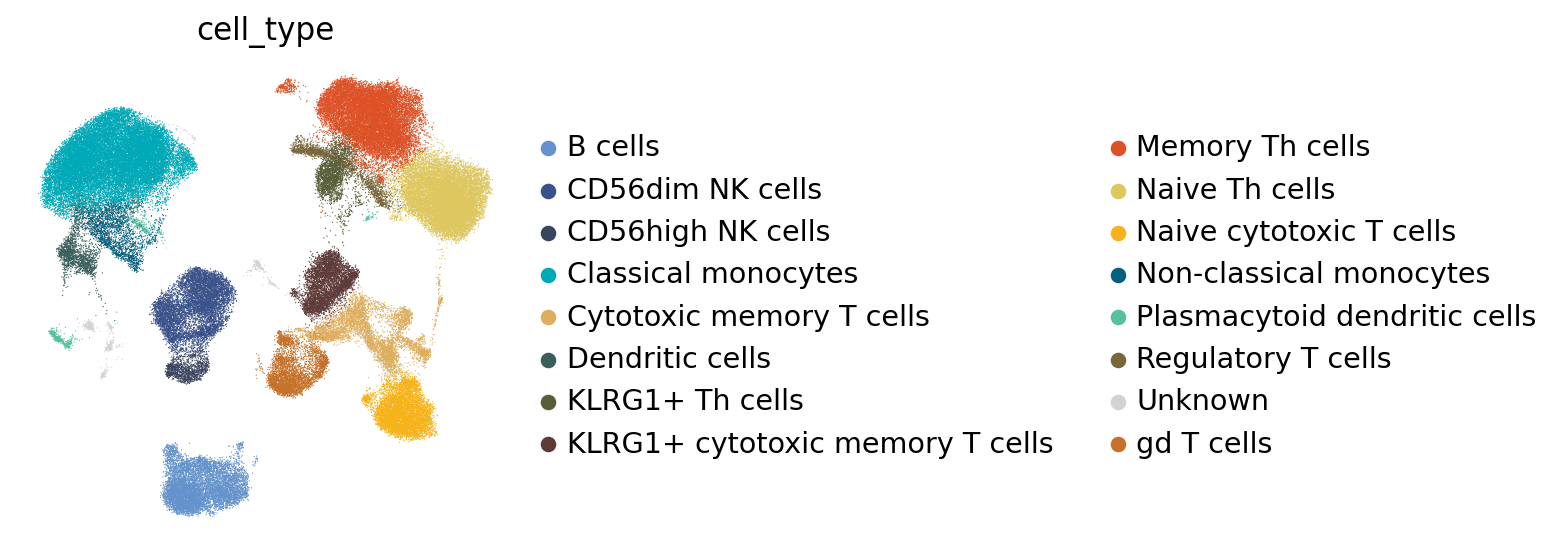

In [54]:
# Compute umap on data space
sc.tl.umap(adata_flow)
sc.pl.umap(adata_flow, color='cell_type', palette=cell_type_colors, frameon=False, save='flow_leiden_umap_PCA.png')

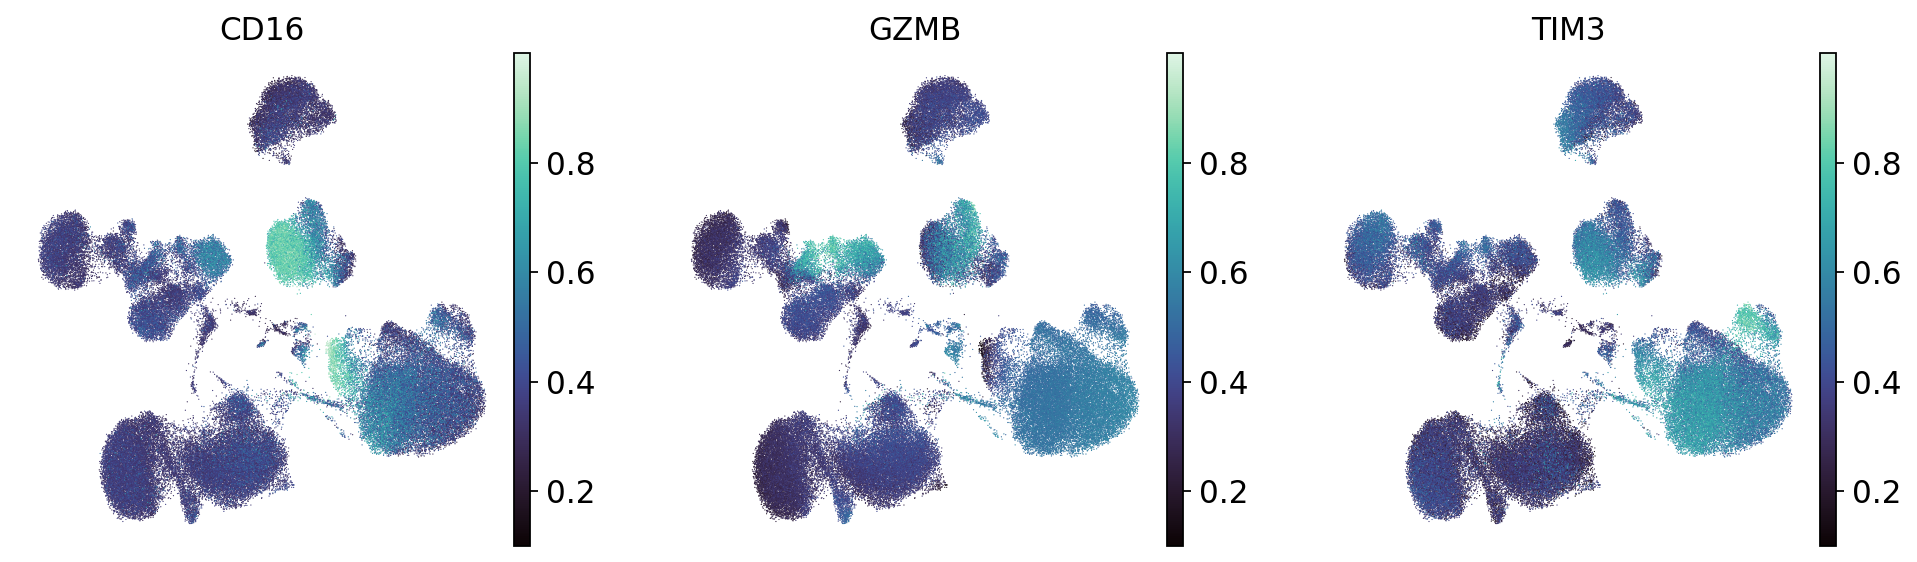

In [60]:
sc.pl.embedding(adata_flow, basis='X_umap_CytoVI_normal_scaled', color=['CD16', 'GZMB', 'TIM3'], cmap='mako', frameon=False, vmin = 0.1, save = 'flow_CD16_GZMB_overlay.png')

In [59]:
# save adata
# adata_flow.write('../data/raw/Spectral flow/Nunez/For Chiquito/annotated/2024-07-18_norm_sample_batch1_ann_clustered_for_fig.h5ad')

In [ ]:
# read adata
adata_flow = ad.read_h5ad('../data/raw/Spectral flow/Nunez/For Chiquito/annotated/2024-07-18_norm_sample_batch1_ann_clustered_for_fig.h5ad')

## load mass cytometry data and inspect latent space

In [3]:
adata_cytof = ad.read('../data/raw/CyTOF/twins/surface/batch1/annotated/2024-05-22_norm_samples_batch1_ann_100k.h5ad')

# remove CD128 from adata due to staining issues in original data
rm_vars = ['CD138']
adata_cytof = adata_cytof[:, [var for var in adata_cytof.var_names if var not in rm_vars]].copy()

model_path = '../models/dist_eval/2024-10-11_CyTOF_normal_scaled'
model_cytof= cytovi.CytoVI.load(model_path, adata = adata_cytof)

/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


INFO     File ../models/dist_eval/2024-10-11_CyTOF_normal_scaled/model.pt already downloaded                       


/home/labs/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torc

In [4]:
# save umap coords
adata_cytof.obsm["X_umap_PCA"] = adata_cytof.obsm['X_umap'].copy()

In [5]:
# generate umap of latent
sc.settings.n_jobs = 20
adata_cytof.obsm["X_CytoVI_normal_scaled"] = model_cytof.get_latent_representation()
sc.pp.neighbors(adata_cytof, use_rep="X_CytoVI_normal_scaled", key_added= 'neighbors_CytoVI_normal_scaled')
sc.tl.umap(adata_cytof, neighbors_key = 'neighbors_CytoVI_normal_scaled')
adata_cytof.obsm["X_umap_CytoVI_normal_scaled"] = adata_cytof.obsm['X_umap'].copy()

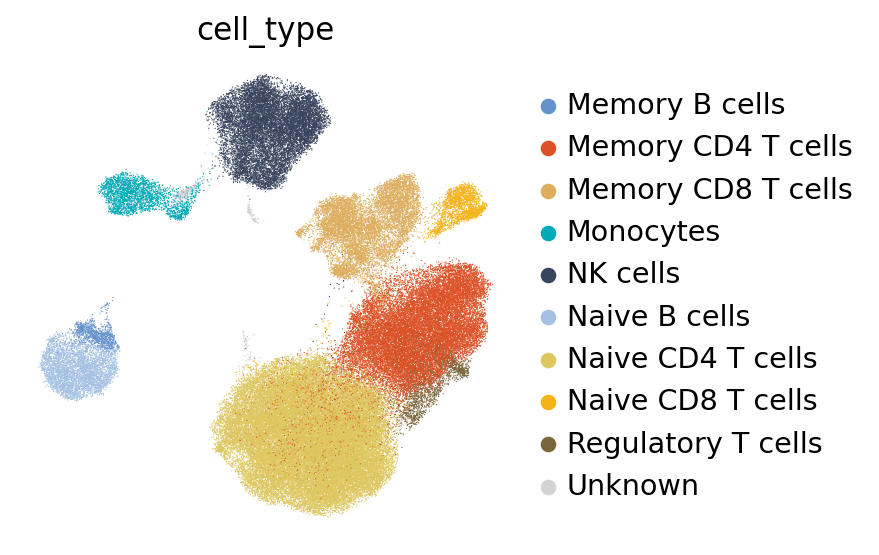

In [6]:
cell_type_colors_cytof = {
    'Memory B cells': '#6492CC',
    'Memory CD8 T cells': '#DEAE5E',
    'Memory CD4 T cells': '#DD5126', 
    'Monocytes': '#00A9B8',
    'Naive CD4 T cells': '#DEC75E',
    'NK cells': '#39445E',
    'Naive CD8 T cells': '#F6B319',
    'Naive B cells': '#A4C1E3',
    'Regulatory T cells': '#79663B', 
    'Unknown': 'lightgrey'
}

sc.pl.umap(adata_cytof, color='cell_type', palette=cell_type_colors_cytof, frameon=False, save='cytof_cell_types.png')

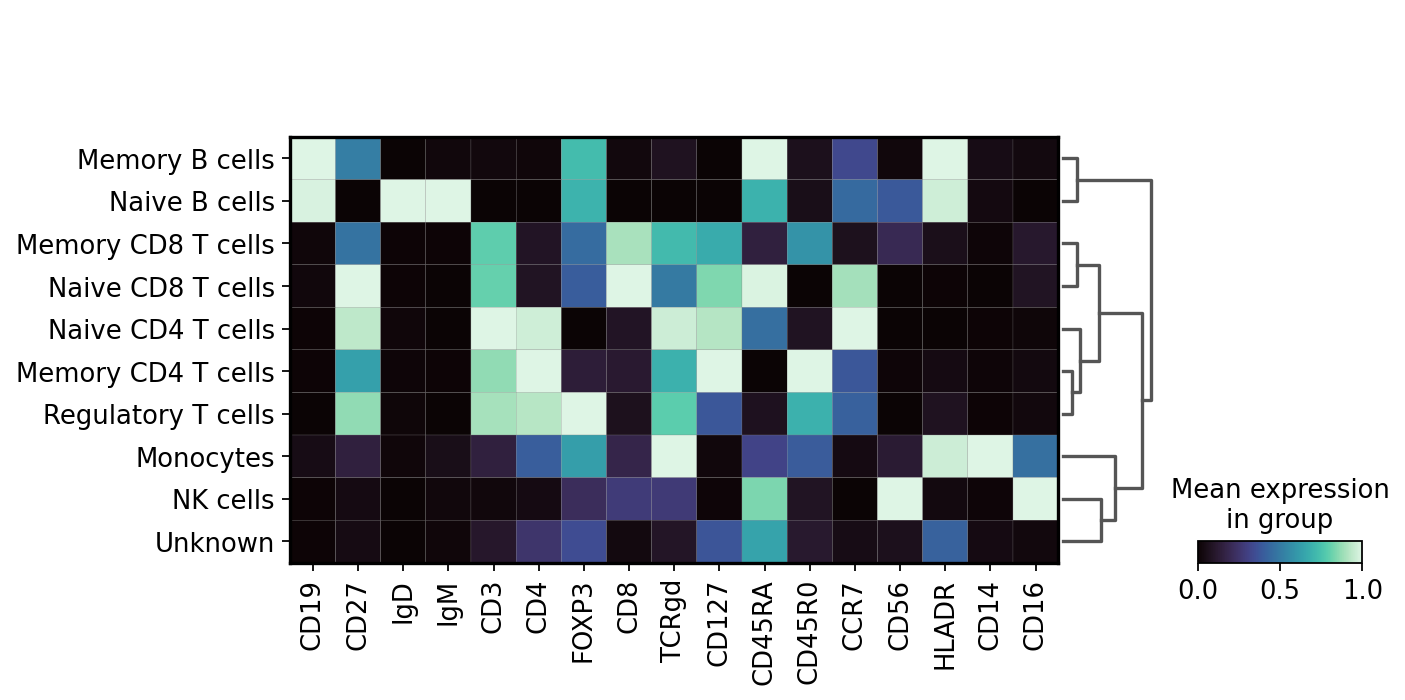

In [88]:
cytof_markers = ['CD19', 'CD27', 'IgD', 'IgM', 'CD3', 'CD4','FOXP3', 'CD8', 'TCRgd', 'CD127', 'CD45RA', 'CD45R0', 'CCR7', 'CD56', 'HLADR', 'CD14', 'CD16']
sc.pl.matrixplot(adata_cytof, var_names=cytof_markers, groupby='cell_type', layer='scaled', standard_scale='var', cmap='mako', dendrogram = True, save = 'cytof_cell_type_expression_heatmap_selected_markers.pdf')

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


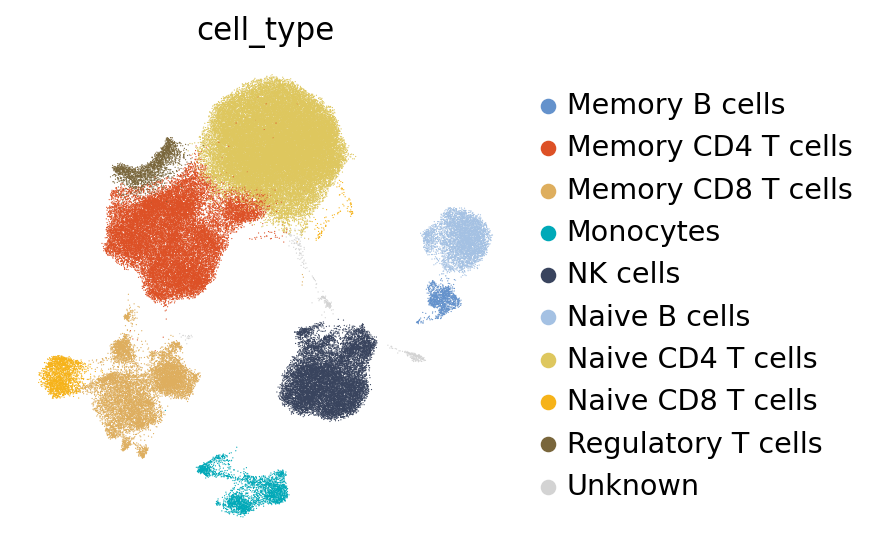

In [89]:
# plot umap on data space
sc.pl.embedding(adata_cytof, basis = 'X_umap_PCA', color='cell_type', palette=cell_type_colors_cytof, frameon=False, save='cytof_cell_types_PCA.png')

In [8]:
# save anndata
adata_cytof.write('../data/raw/CyTOF/twins/surface/batch1/annotated/2024-11-05_norm_samples_batch1_ann_100k_clustered_for_fig.h5ad')

## load CITE-seq data and inspect latent space

In [91]:
adata_cite_seq = ad.read_h5ad('../data/raw/CITE_seq/Seurat_PBMC/2024-02-16_cite_seq_processed.h5ad')
adata_cite_seq = adata_cite_seq[adata_cite_seq.obs['orig.ident'].isin(['P7_0'])].copy()

model_path = '../models/dist_eval/2024-07-10_CITE_seq_normal_scaled/'
model_citeseq= cytovi.CytoVI.load(model_path, adata = adata_cite_seq)

INFO     File ../models/dist_eval/2024-07-10_CITE_seq_normal_scaled/model.pt already downloaded                    


In [92]:
# save umap coords
adata_cite_seq.X = adata_cite_seq.layers['scaled'].copy()
sc.tl.pca(adata_cite_seq, n_comps=20)
sc.pp.neighbors(adata_cite_seq)
sc.tl.umap(adata_cite_seq)
adata_cite_seq.obsm["X_umap_PCA"] = adata_cite_seq.obsm['X_umap'].copy()

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


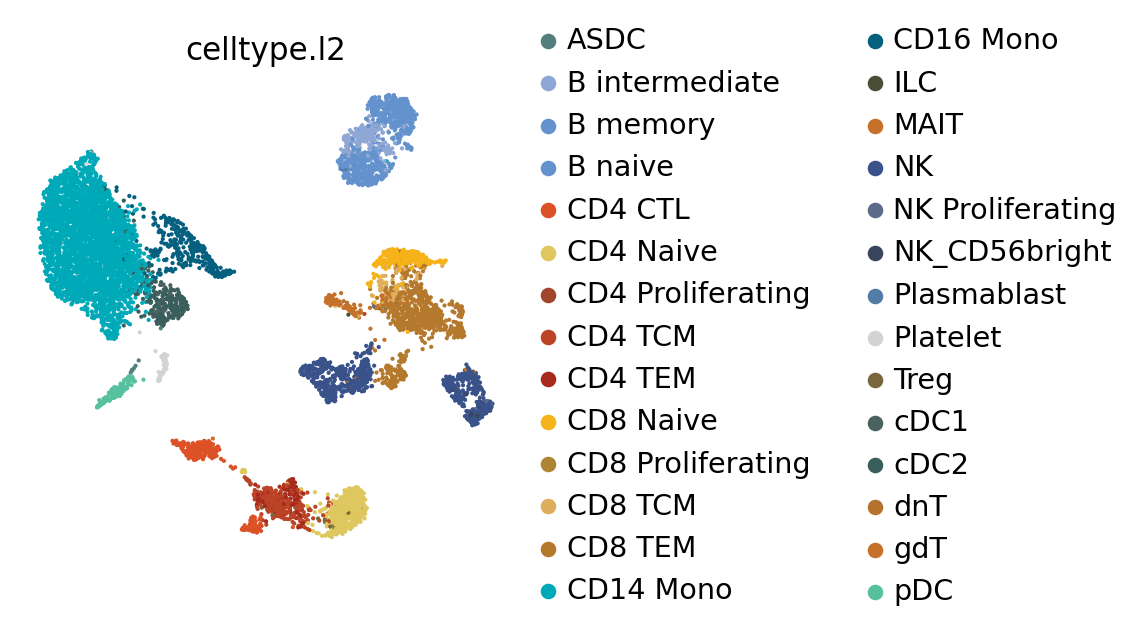

In [96]:
cell_type_colors_cite_seq = {
    'B naive': '#6492CC',
    'CD14 Mono': '#00A9B8', 
    'NK': '#3A528A',
    'CD8 TCM': '#DEAE5E',
    'CD4 CTL': '#DD5126', 
    'CD4 TCM': '#BB4326',
    'pDC': '#56C09F',
    'Treg': '#79663B',
    'CD4 Naive': '#DEC75E',
    'CD8 TEM': '#B5792E',
    'CD8 Naive': '#F6B319',
    'cDC2': '#395E5C',
    'gdT': '#C67129',
    'CD16 Mono': '#056080', 
    'CD4 TEM': '#A6291C',
    'B intermediate': '#8FA7D4',
    'B memory': '#6492CC', 
    'MAIT': '#C67129',
    'Plasmablast': '#527BA6',
    'NK_CD56bright': '#39445E',
    'Platelet': '#D3D3D3', 
    'NK Proliferating': '#5C6B8A',
    'ASDC': '#527F7D', 
    'cDC1': '#4A6362',
    'dnT': '#B5722E',
    'ILC': '#4D4E38',
    'CD8 Proliferating': '#AD8533', 
    'CD4 Proliferating': '#A1462B', 
}

sc.pl.umap(adata_cite_seq, color='celltype.l2', palette=cell_type_colors_cite_seq, frameon=False, save='citeseq_cell_types_umap_pca.png')

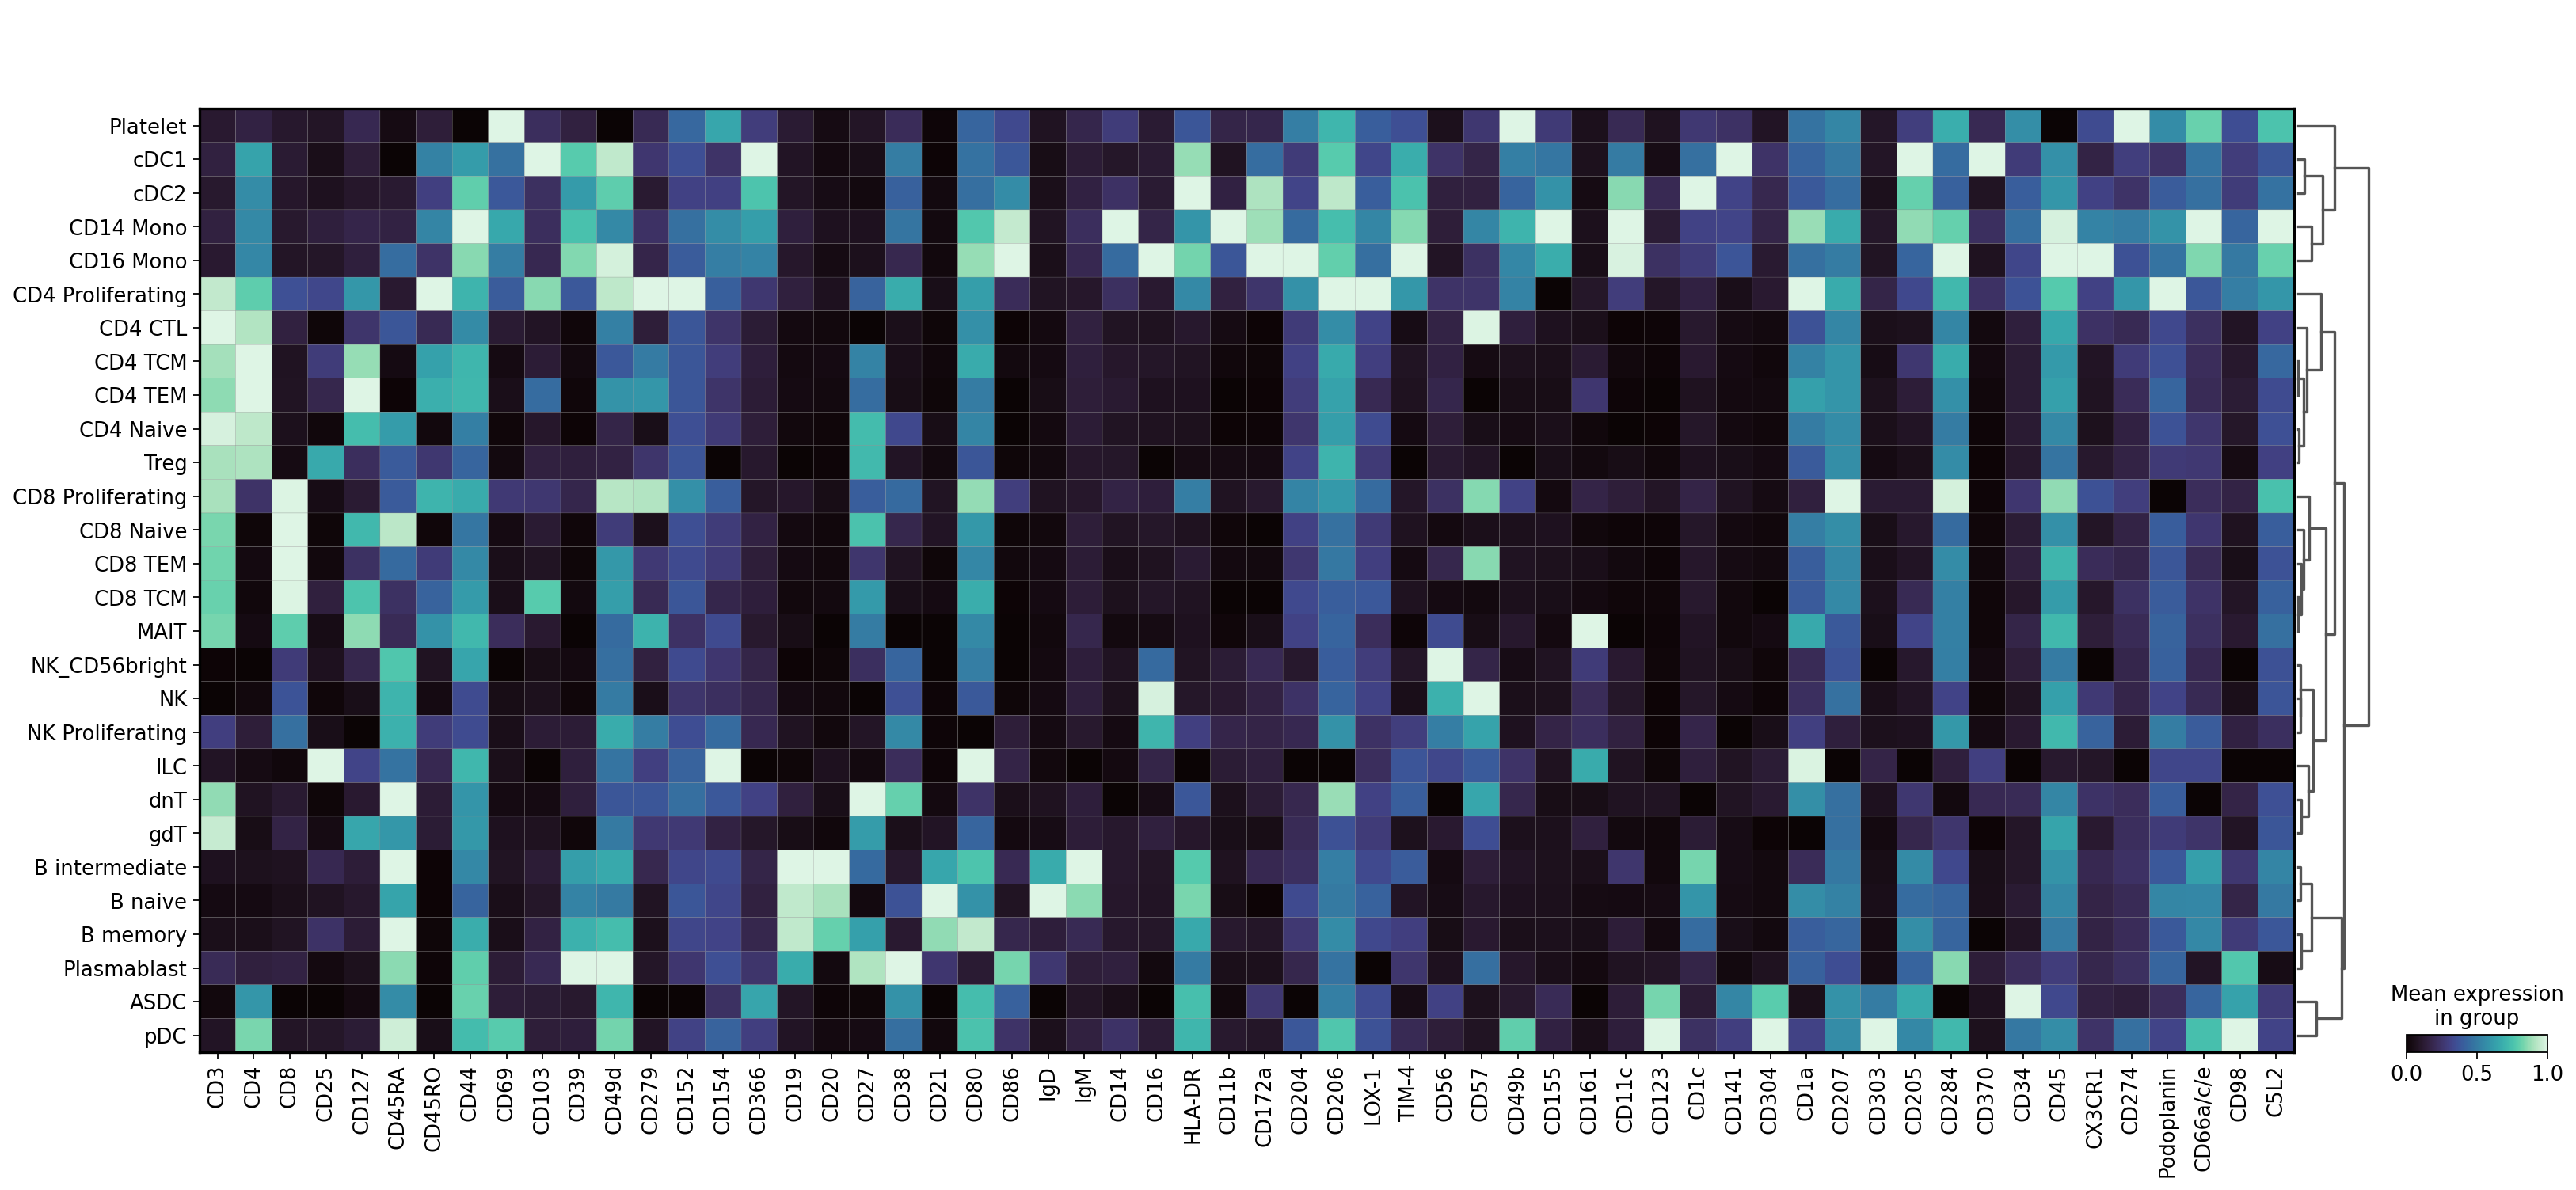

In [108]:
cite_seq_markers = [
    'CD3', 'CD4', 'CD8', 'CD25', 'CD127', 'CD45RA', 'CD45RO', 'CD44', 'CD69', 'CD103', 'CD39', 'CD49d', 'CD279', 'CD152', 'CD154', 'CD366',
    'CD19', 'CD20', 'CD27', 'CD38', 'CD21', 'CD80', 'CD86', 'IgD', 'IgM', 'CD14', 'CD16', 'HLA-DR', 'CD11b', 'CD172a', 'CD204', 'CD206', 'LOX-1', 'TIM-4',
    'CD56', 'CD57', 'CD49b', 'CD155', 'CD161', 'CD11c', 'CD123', 'CD1c', 'CD141', 'CD304', 'CD1a', 'CD207', 'CD303', 'CD205', 'CD284', 'CD370',
    'CD34', 'CD45', 'CX3CR1', 'CD274', 'Podoplanin', 'CD66a/c/e', 'CD98', 'C5L2',
]

sc.pl.matrixplot(adata_cite_seq, var_names=cite_seq_markers, groupby='celltype.l2', layer='scaled', standard_scale='var', cmap='mako', dendrogram = True, save = 'cite_seq_cell_type_expression_heatmap_selected_markers.pdf')

In [97]:
# generate umap of latent
adata_cite_seq.obsm["X_CytoVI_normal_scaled"] = model_citeseq.get_latent_representation()
sc.pp.neighbors(adata_cite_seq, use_rep="X_CytoVI_normal_scaled", key_added= 'neighbors_CytoVI_normal_scaled')
sc.tl.umap(adata_cite_seq, neighbors_key = 'neighbors_CytoVI_normal_scaled')
adata_cite_seq.obsm["X_umap_CytoVI_normal_scaled"] = adata_cite_seq.obsm['X_umap'].copy()

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


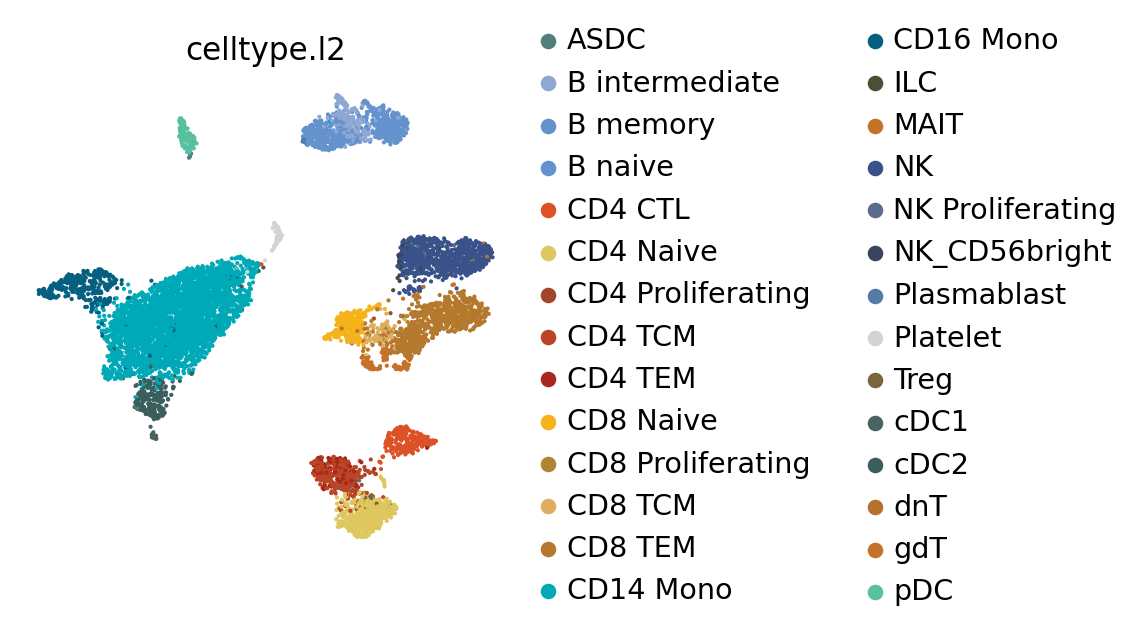

In [98]:
sc.pl.umap(adata_cite_seq, color='celltype.l2', palette=cell_type_colors_cite_seq, frameon=False, save='citeseq_cell_types.png')

In [99]:
# save anndata
adata_cite_seq.write('../data/raw/CITE_seq/Seurat_PBMC/2024-07-29_cite_seq_processed_P7_for_fig.h5ad')

## Batch correction for flow cytometry

In [109]:
# read data
adata_flow_batch = ad.read_h5ad('../data/2024-01-16_model_eval_multi_batch/2024-01-26_nunez_norm.h5ad')

In [22]:
# export expression, var_names and obs csv for external packages
expr = adata_flow_batch.layers['scaled']
var_names = adata_flow_batch.var_names
obs = adata_flow_batch.obs

expr_df = pd.DataFrame(expr, columns=var_names)

expr_df.to_csv('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-06-05_aurora_batch_figure_expression.csv')
obs.to_csv('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-06-05_aurora_batch_figure_obs.csv')

In [23]:
# export expression, var_names and obs csv for external packages
expr = adata_flow_batch.layers['transformed']
expr_df = pd.DataFrame(expr, columns=var_names)

expr_df.to_csv('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-06-05_aurora_batch_figure_expression_transformed.csv')

In [110]:
# load transformations from cycombine
expr_z_scaled = pd.read_csv('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-06-05_aurora_batch_figure_expression_cycombine_standard_scaled.csv', index_col=0)
expr_rank_scaled = pd.read_csv('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-06-05_aurora_batch_figure_expression_cycombine_rank_scaled.csv', index_col=0)

# add scaled expr
adata_flow_batch.layers['scaled_z'] = expr_z_scaled.to_numpy()
adata_flow_batch.layers['scaled_rank'] = expr_rank_scaled.to_numpy()

In [25]:
# # save adata with transformations
# adata_flow_batch.write('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-06-14_aurora_batch_figure_scaling_variants.h5ad')

In [111]:
# read adata with trained CytoVI latents
adata_flow_batch = ad.read_h5ad('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-07-10_aurora_batch_new_hyper_latents_umap.h5ad')

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


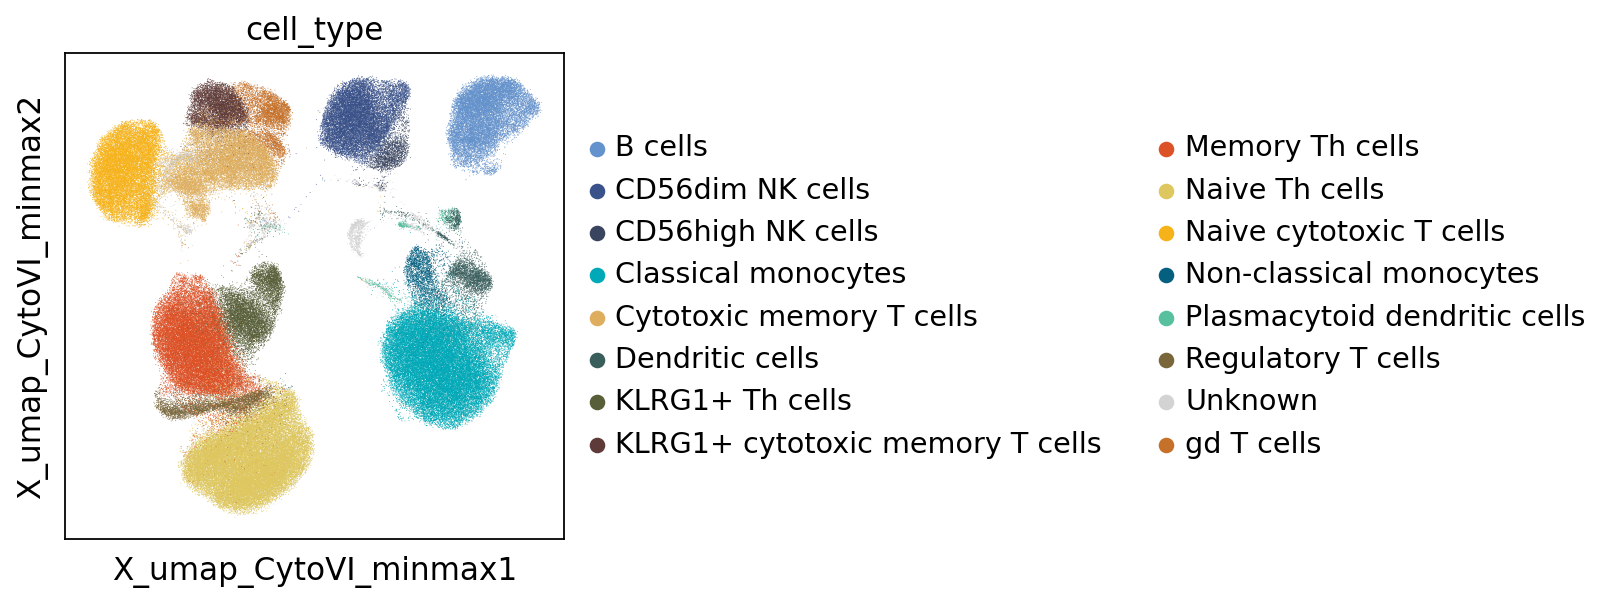

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


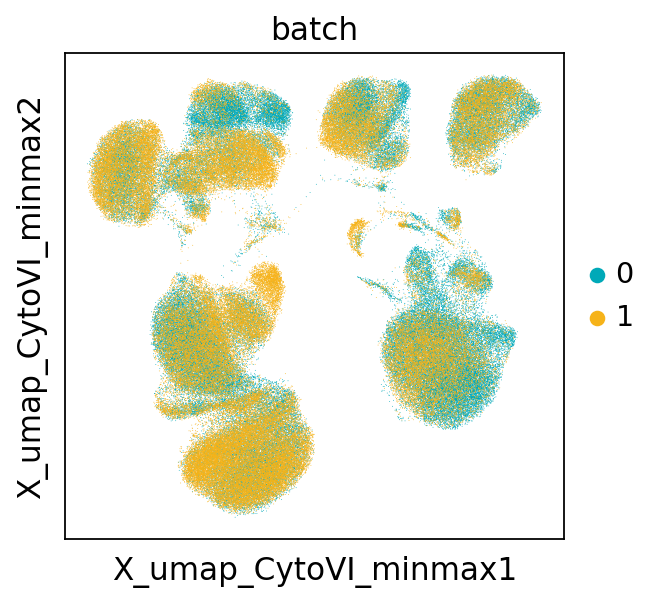

In [113]:
cell_type_colors = {
    'Naive cytotoxic T cells': '#F6B319',
    'Classical monocytes': '#00A9B8',
    'Cytotoxic memory T cells': '#DEAE5E',
    'Memory Th cells': '#DD5126',
    'CD56dim NK cells': '#3A528A',
    'B cells': '#6492CC',
    'Naive Th cells': '#DEC75E',
    'KLRG1+ cytotoxic memory T cells': '#5E3B39',
    'gd T cells': '#C67129',
    'Unknown': 'lightgrey',
    'Non-classical monocytes': '#056080',
    'CD56high NK cells': '#39445E',
    'KLRG1+ Th cells': '#575E38',
    'Regulatory T cells': '#79663B',
    'Dendritic cells': '#395E5C',
    'Plasmacytoid dendritic cells': '#56C09F'
}

sc.pl.embedding(adata_flow_batch, basis = 'X_umap_CytoVI_minmax', color = ['cell_type'], palette = cell_type_colors)

batch_colors = ['#00A9B8', '#F6B319']
sc.pl.embedding(adata_flow_batch, basis = 'X_umap_CytoVI_minmax', color = ['batch'], palette = batch_colors)

In [ ]:
# inspect latents
sc.pl.embedding(adata_flow_batch, basis =  'X_umap_CytoVI_zscore', color = ['cell_type', 'batch'])
sc.pl.embedding(adata_flow_batch, basis =  'X_umap_CytoVI_minmax', color = ['cell_type', 'batch'])
sc.pl.embedding(adata_flow_batch, basis =  'X_umap_CytoVI_rank', color = ['cell_type', 'batch'])

In [115]:
# read corrected expression from cycombine
adata_flow_batch.layers['X_cycombine_minmax'] = pd.read_csv('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-06-05_aurora_batch_figure_expression_cycombine_corr.csv', index_col=0).to_numpy()
adata_flow_batch.layers['X_cycombine_zscore'] = pd.read_csv('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-06-05_aurora_batch_figure_expression_cycombine_corr_scaled.csv', index_col=0).to_numpy()
adata_flow_batch.layers['X_cycombine_rank'] = pd.read_csv('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-06-05_aurora_batch_figure_expression_cycombine_corr_rank.csv', index_col=0).to_numpy()

In [116]:
# add obsm fields for cycombine
adata_flow_batch.obsm['X_cycombine_minmax'] = adata_flow_batch.layers['X_cycombine_minmax']
adata_flow_batch.obsm['X_cycombine_zscore'] = adata_flow_batch.layers['X_cycombine_zscore']
adata_flow_batch.obsm['X_cycombine_rank'] = adata_flow_batch.layers['X_cycombine_rank']

In [117]:
# add unintegrated obsm fields
adata_flow_batch.obsm['X_unintegrated_minmax'] = adata_flow_batch.layers['scaled']
adata_flow_batch.obsm['X_unintegrated_zscore'] = adata_flow_batch.layers['scaled_z']
adata_flow_batch.obsm['X_unintegrated_rank'] = adata_flow_batch.layers['scaled_rank']
adata_flow_batch.layers

Layers with keys: raw, scaled, scaled_rank, scaled_z, transformed, X_cycombine_minmax, X_cycombine_zscore, X_cycombine_rank

In [ ]:
# run harmony
from harmony import harmonize
adata_flow_batch.obsm['X_harmony_minmax'] = harmonize(adata_flow_batch.obsm['X_unintegrated_minmax'], adata_flow_batch.obs, batch_key = 'batch')
adata_flow_batch.obsm['X_harmony_zscore'] = harmonize(adata_flow_batch.obsm['X_unintegrated_zscore'], adata_flow_batch.obs, batch_key = 'batch')
adata_flow_batch.obsm['X_harmony_rank'] = harmonize(adata_flow_batch.obsm['X_unintegrated_rank'], adata_flow_batch.obs, batch_key = 'batch')

In [119]:
# compute umaps and save
latent_obsm_keys = ['X_unintegrated_minmax', 'X_unintegrated_zscore', 'X_unintegrated_rank', 'X_harmony_minmax', 'X_harmony_zscore', 'X_harmony_rank', 'X_CytoVI_minmax', 'X_CytoVI_rank', 'X_CytoVI_zscore', 'X_cycombine_minmax', 'X_cycombine_zscore', 'X_cycombine_rank']

for key in latent_obsm_keys:
    sc.pp.neighbors(adata_flow_batch, use_rep=key)
    sc.tl.umap(adata_flow_batch)
    adata_flow_batch.obsm[f"X_umap_{key[2:]}"] = adata_flow_batch.obsm['X_umap'].copy()

In [ ]:
# save all embeddings
for key in latent_obsm_keys:
    sc.pl.embedding(adata_flow_batch, basis =  f'X_umap_{key[2:]}', color = ['cell_type', 'batch'], save = f'embedding_multi_batch_{key[2:]}.png')

In [121]:
# save anndata on disk
adata_flow_batch.write('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-07-30_aurora_batch_new_hyper_latents_umap_bm_comp.h5ad')

# scib

In [135]:
# perform scib
adata_bm = adata_flow_batch[adata_flow_batch.obs['cell_type'] != 'Unknown', :].copy()
adata_bm.obs['cell_type'].cat.remove_unused_categories(inplace=True)

adata_bm = cytovi.pp.subsample(adata_bm, n_obs = 20000, groupby = 'batch').copy()

latent_obsm_keys = ['X_unintegrated_minmax', 'X_unintegrated_zscore', 'X_unintegrated_rank', 'X_harmony_minmax', 'X_harmony_zscore', 'X_harmony_rank', 'X_CytoVI_minmax', 'X_CytoVI_rank', 'X_CytoVI_zscore', 'X_cycombine_minmax', 'X_cycombine_zscore', 'X_cycombine_rank']

adata_bm.X = adata_bm.layers['scaled'].copy()

The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.


In [141]:
# perform the actual benchmarking
from scib_metrics.benchmark import Benchmarker, BioConservation

biocon = BioConservation(nmi_ari_cluster_labels_leiden = True, nmi_ari_cluster_labels_kmeans = False)

bm = Benchmarker(
    adata_bm,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=latent_obsm_keys,
    pre_integrated_embedding_obsm_key='X_unintegrated_minmax',
    bio_conservation_metrics = biocon
    # n_jobs=60,
)
bm.benchmark()

Computing neighbors:   0%|          | 0/12 [00:00<?, ?it/s]

Embeddings: 100%|██████████| 12/12 [03:25<00:00, 17.15s/it]


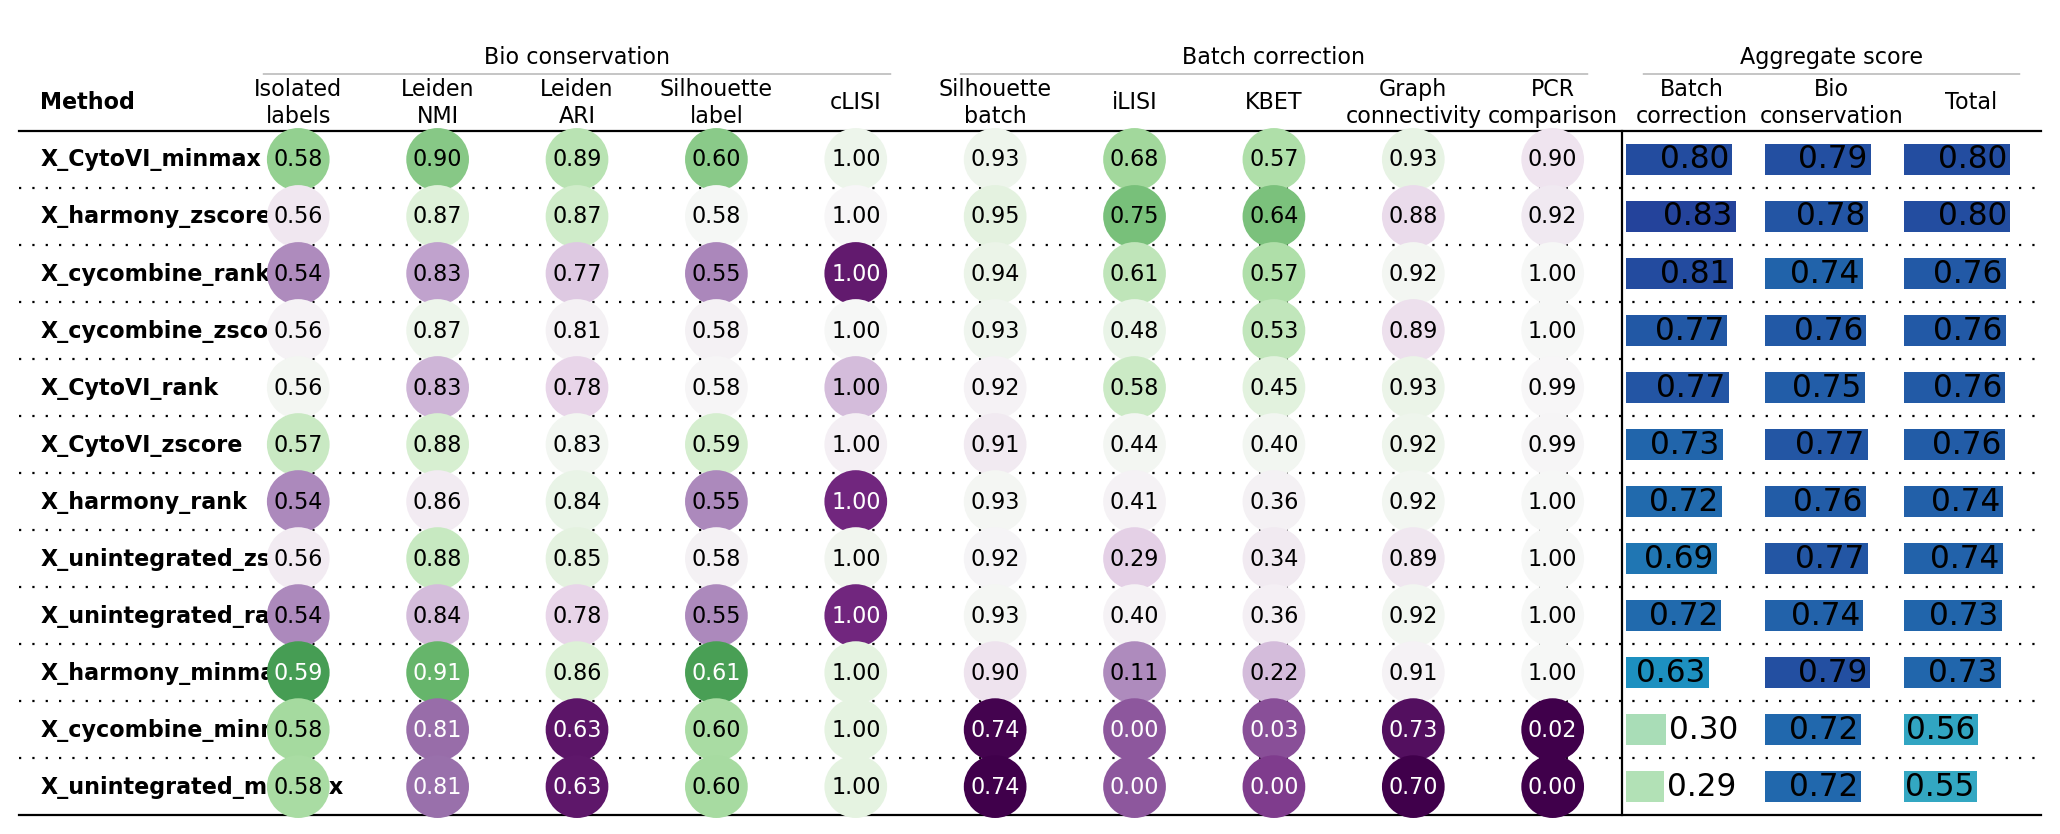

In [142]:
bm.plot_results_table(min_max_scale = False, show = False)

In [143]:
# save bm results as csv
bm.get_results(min_max_scale=False).to_csv('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-06-28_aurora_batch_figure_scib_results.csv')

In [144]:
# read again and do costumn plotting
bm_res = pd.read_csv('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-06-28_aurora_batch_figure_scib_results.csv', index_col = 0)

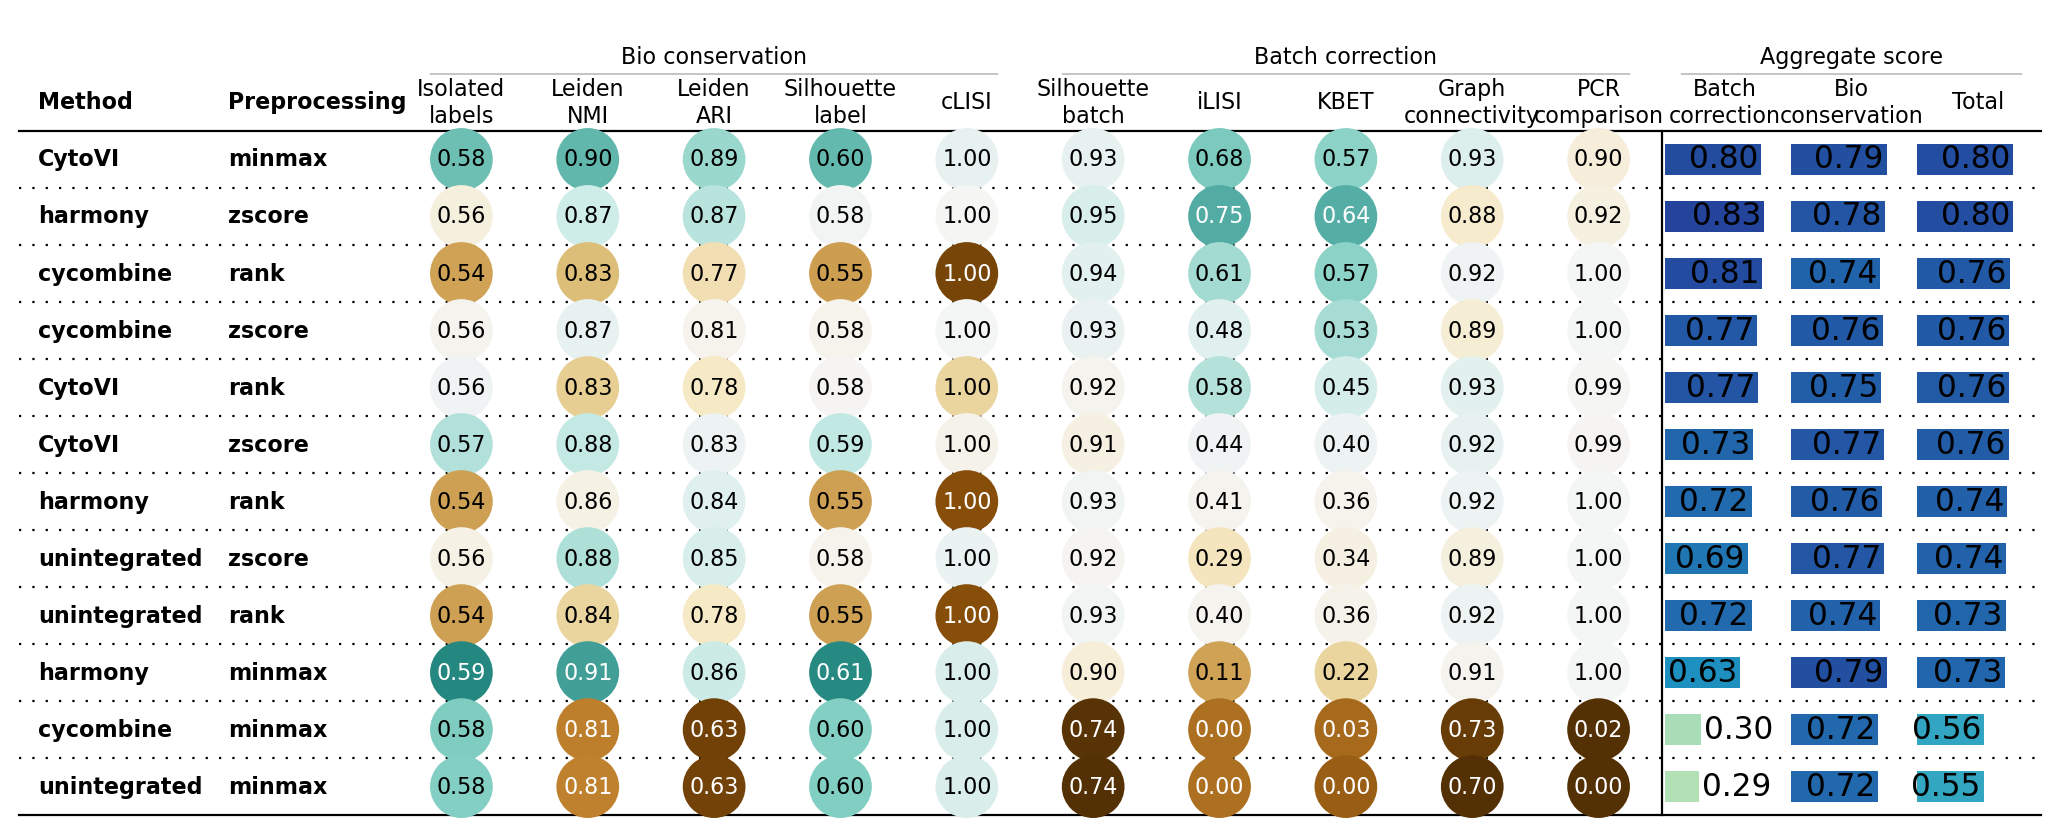

In [171]:
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import bar
import matplotlib.pyplot as plt
import numpy as np

cmap_fn = lambda col_data: normed_cmap(col_data, cmap=plt.cm.BrBG, num_stds=2.5)

# Drop 'Metric Type' from the DataFrame
plot_df = bm_res.drop('Metric Type', axis=0)
num_embeds = plot_df.shape[0]

# Sort by total score
plot_df = plot_df.sort_values(by="Total", ascending=False).astype(np.float64)
plot_df["Method"] = plot_df.index

# Split the Method column into two columns, filling missing parts with empty strings
split_methods = plot_df['Method'].str.split('_', n=2, expand=True)
plot_df['Method'] = split_methods[1]
plot_df['Preprocessing'] = split_methods[2]
# plot_df['Method_Part2'] = split_methods[1].fillna('')

# Rearrange the columns to put the new Method_Part1 and Method_Part2 columns at the beginning
cols = ['Method', 'Preprocessing'] + [col for col in plot_df.columns if col not in ['Method', 'Preprocessing']]
plot_df = plot_df[cols]

# plot_df = plot_df.drop(columns=['Method'])

# Split columns by metric type
score_cols = bm_res.columns[bm_res.loc['Metric Type'] == 'Aggregate score']
other_cols = bm_res.columns[bm_res.loc['Metric Type'] != 'Aggregate score']
other_cols = [col for col in other_cols if col != 'New_col']

column_definitions = [
    ColumnDefinition("Method", width=1.5, textprops={"ha": "left", "weight": "bold"}),
    ColumnDefinition("Preprocessing", width=1.5, textprops={"ha": "left", "weight": "bold"}),
]

# Circles for the metric values
column_definitions += [
    ColumnDefinition(
        col,
        title=col.replace(" ", "\n", 1),
        width=1,
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "circle", "pad": 0.25},
        },
        cmap=cmap_fn(plot_df[col]),
        group=bm_res.loc['Metric Type', col],
        formatter="{:.2f}",
    )
    for i, col in enumerate(other_cols)
]

# Bars for the aggregate scores
column_definitions += [
    ColumnDefinition(
        col,
        width=1,
        title=col.replace(" ", "\n", 1),
        plot_fn=bar,
        plot_kw={
            "cmap": plt.cm.YlGnBu,
            "plot_bg_bar": False,
            "annotate": True,
            "height": 0.9,
            "formatter": "{:.2f}",
        },
        group=bm_res.loc['Metric Type', col],
        border="left" if i == 0 else None,
    )
    for i, col in enumerate(score_cols)
]

# Allow to manipulate text post-hoc (in illustrator)
size = 1

with plt.rc_context({"svg.fonttype": "none"}):
    fig, ax = plt.subplots(figsize=(len(bm_res.columns) * 1.25 * size, 3 + 0.3 * num_embeds * size))
    tab = Table(
        plot_df,
        cell_kw={
            "linewidth": 0,
            "edgecolor": "k",
        },
        column_definitions=column_definitions,
        ax=ax,
        row_dividers=True,
        footer_divider=True,
        textprops={"fontsize": 10, "ha": "center"},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
        col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
        column_border_kw={"linewidth": 1, "linestyle": "-"},
        index_col='Method', 
    ).autoset_fontcolors(colnames=plot_df.columns)

plt.show()
fig.savefig(os.path.join(figure_dir, "scib_results.pdf"), facecolor=ax.get_facecolor(), dpi=300)

